### Задача 1

Так как специалисту по машинному обучению часто приходится сталкиваться с различными API и их документацией необходимо уметь с этим работать.
В рамках задачи нужно используя документацию https://yandex.ru/dev/direct/ получить токен песочницы написать на Python код собирающий данные по рекламным кампаниям Яндекс директ.

Как результат ожидается код для получения данных по кампаниям.

**Банк крупный рекламодатель в залоговом кредитовании, подумайте, какие показатели нам были бы интересны и как можно использовать данное API для улучшения показателей банка?**

In [69]:
# импортируем необходимые библиотеки
import requests, json
from time import sleep
from pprint import pprint

#  метод для корректной обработки строк в кодировке UTF-8
def u(x):
    if type(x) == type(b''):
        return x.decode('utf8')
    else:
        return x

# массив интервалов задержек
delays = [360, 540, 720, 900, 1080]

# ошибка "Недостаточно баллов"
notEnoughUnitsError = "152"

#  адрес сервисов для отправки JSON-запросов
CampaignsURL = 'https://api-sandbox.direct.yandex.com/json/v5/campaigns'
AdGroupsURL = 'https://api-sandbox.direct.yandex.com/json/v5/adgroups'
AdsURL = 'https://api-sandbox.direct.yandex.com/json/v5/ads'

# OAuth-токен пользователя, от имени которого будут выполняться запросы
token = 'y0_AgAAAAAzZ69TAAqWjwAAAADuIVKiTmywVTDASnydKNvFZYjzJUvhclY'

#  создание HTTP-заголовков запроса
headers = {"Authorization": "Bearer " + token,  
           "Accept-Language": "ru",  
           }

campaign_field = ['BlockedIps', 'ExcludedSites', 'Currency', 'DailyBudget', 'Notification', 'EndDate', 'Funds',
                   'ClientInfo', 'Id', 'Name', 'NegativeKeywords', 'RepresentedBy', 'StartDate', 'CreateTime',
                   'Statistics', 'State', 'Status', 'StatusPayment', 'StatusClarification', 'SourceId', 'TimeTargeting',
                   'TimeZone', 'Type']

adgroup_field = ['Id', 'CampaignId', 'Status', 'Name', 'RegionIds', 'RestrictedRegionIds', 'NegativeKeywords',
       'NegativeKeywordSharedSetIds', 'Type', 'TrackingParams', 'Subtype', 'ServingStatus']

ads_field = ['AdCategories', 'AgeLabel', 'AdGroupId', 'CampaignId', 'Id', 'State', 'Status', 'StatusClarification', 'Type',
       'Subtype']


# создание тела запроса
# запрашиваем информацию о всех рекдамных компаниях

campaign_body = {"method": "get",  # используемый метод.
        "params": {"SelectionCriteria": {}, 
                   "FieldNames": campaign_field  # имена параметров, которые требуется получить.
                   }}

# Для более подробной информации в качестве примера рассмотрим только одну рекламную кампанию (при желании подобную информацию можно
# получить по всем рекламным кампаниям)
# Получим информацию по группам объявлений и самим объявлениям для кампании с id = 459895

some_campaign_id = 459895

adgroup_body = {"method": "get",  
        "params": {"SelectionCriteria":  {'CampaignIds': [some_campaign_id]},
                   "FieldNames": adgroup_field  
                   }}

ads_body = {"method": "get",  
        "params": {"SelectionCriteria": {'CampaignIds': [some_campaign_id]}, 
                   "FieldNames": ads_field  
                   }}

# кодирование тела запроса в JSON
campaign_body_json = json.dumps(campaign_body, ensure_ascii=False).encode('utf8')
adgroup_body_json = json.dumps(adgroup_body, ensure_ascii=False).encode('utf8')
ads_body_json = json.dumps(ads_body, ensure_ascii=False).encode('utf8')


def do_request(url, jsonBody):
    for delay in delays:
        # выполнение запроса, получение результата
        result = requests.post(url, jsonBody, headers=headers)

        # обработка запроса
        if result.status_code == 200:
            # если получен HTTP-код 200, то обрабатываем тело ответа

            # если в результирующих данных не содержится первичного ключа error, значит, запрос был выполнен успешно
            if not result.json().get("error", False):
                # если ответ содержит параметр LimitedBy, значит, были получены не все доступные объекты.
                if result.json()['result'].get('LimitedBy', False):
                    # в этом случае следует выполнить дополнительные запросы для получения всех объектов.
                    print("Получены не все доступные объекты.")

                return result.json()["result"]

            # обработка ошибок запроса к серверу API Директа
            else:
                error_ = result.json()['error']
                if error_.get('error_code', 0) == notEnoughUnitsError:
                    # недостаточно баллов для выполнения запроса
                    print("Повторный запрос через {} секунд".format(delay))
                    # задержка перед выполнением следующего запроса
                    sleep(delay)
                else:
                    raise RuntimeError(error_)

        # обработка других ошибок
        else:
            raise RuntimeError(result)

try:
    result_campaign = do_request(CampaignsURL, campaign_body_json)
    result_adgroups = do_request(AdGroupsURL, adgroup_body_json)
    result_ads = do_request(AdsURL, ads_body_json)
    
    print('Information about CAMPAIGNS')
    pprint(result_campaign)
    print('\n\n')
    print('Information about ADGROUPS for campaign_id = 459895')
    pprint(result_adgroups)
    print('\n\n')
    print('Information about ADS for campaign_id = 459895')
    pprint(result_ads)
    
    # сейчас эта информация просто выводится на экран, но в дальнейшей её нужно будет сохранить для работы с ней
    
except RuntimeError as e:
    print(e)


Information about CAMPAIGNS
{'Campaigns': [{'BlockedIps': None,
                'ClientInfo': 'Двирник Юлия',
                'CreateTime': '2023-10-02T22:45:33Z',
                'Currency': 'RUB',
                'DailyBudget': None,
                'EndDate': None,
                'ExcludedSites': None,
                'Funds': {'CampaignFunds': {'Balance': 0,
                                            'BalanceBonus': 0,
                                            'Sum': 10000000000,
                                            'SumAvailableForTransfer': 0},
                          'Mode': 'CAMPAIGN_FUNDS'},
                'Id': 459895,
                'Name': 'Test API Sandbox campaign 1',
                'NegativeKeywords': {'Items': ['keyword1',
                                               'keyword2',
                                               'keyword3']},
                'Notification': {'EmailSettings': {'CheckPositionInterval': 15,
                                   

Ячейка Markdown в которой можно написать свои мысли по использованию API, чтобы продавать кредитов больше или тратить для этого на рекламу меньше:

План работы:
1. Изучить API на офф сайте.
    Обнаружены 3 основные сущности с которыми предстоит работать: рекламная кампания, группа объявлений и объявление

2. Получить все три сущности
а) получим все кампании
б) группы внутри одной выбранной кампании
в) объявления внутри одной выбранной кампании

2. Среди аттрибутов этих сущностей выбрать те, что могут быть полезны для дальнейшей аналитики
    (см. поля для каждой из сущностей соответственно в campaign_field, adgroup_field, ads_field)

Я не маркетолог, но предполагаю, что интересующим показателем в рекламной кампании для банка будет цена привлечения клиента, и
в целом, факторы, влияющие на привлечение клиента (на каком сайте, какие ключевые слова, в какое время надо показывать посетителю, 
чтобы он с большей вероятностью стал клиентом).
На данный момент мне не понятно, можем ли мы отследить стал ли посетитель клиентом, по крайней мере, мы можем отследить переход по объявлению
Если у нас есть есть информация по полной цепочке (с информацией, выполнил ли посетитель целовое действие), то это будет более полезно
Например, банку не нужен пустой кликбейт, банк потеряет бюджет рекламной кампании, а разочарованные посетители не станут клиентами банка.

Дальнейшие действия:

1. Проанализировать простые статистики (выберем за интересующую нас метрику стоимость привлечения клиента или подобное) 
а) Среди кампаний. Возможно какие-то кампании были проведены лучше других, если наблююдается существенный разброс, углубиться в это
б) Среди групп объявлений внутри конкретной кампании. То же самое

2. При углублении анализа нам будут полезны аггрегированные (среднее, мин, макс) фичи из объявлений, включающие но не ограничивающиеся:
- ключевыми словами (тут извлечь признаки понадобится, например сделать one-hot encoding если ключевых слов не очень много, иначе попробовать эмбеддинги, то с этим у меня нет опыта)
- ставками и стоимость показа
- городами
- и тд
3. feature engineering:
- например, цены стоит нормализовать на средние по городам/компаниям, т.к. они могут играть большую роль чем абсолютные величины

4. составим таблицу (удобнее всего в пандас)
Исходные данные + аггрегированные даннные + feature engineering + интересующая нас метрика
С такой таблицей дальше будет удобно проводить анализ средствами статистики и ML

### Задача 2

Базовое знание XML полезно для работы, так как в данном формате происходит обмен информацией между внешними источниками и системой принятия решений (СПР) банка. В рамках задачи необходимо написать код, получающий информацию о каталоге CD дисков с адреса https://www.w3schools.com/xml/cd_catalog.xml .

Данная задача должна показать ваши навыки по работе с XML форматом, поэтому уход в pandas не приветствуется, так как в реальной рабочей задаче будут технические ограничения по работе с pandas.

Напишите код, который:

1)         Считает стоимость всех дисков в каталоге.

2)         Какой год для дисков в каталоге является последним (самым современным)

3)         Компания «Polydor» сменила своё название на «Poly», измените название этой компании у всех CD на актуальное в XML каталоге и сохраните новый XML файл

In [205]:
import xml.etree.cElementTree as ET
import urllib.request
from decimal import Decimal

URL = 'https://www.w3schools.com/xml/cd_catalog.xml'

# as file is small we can read and load it full
response = urllib.request.urlopen(URL).read()
tree = ET.fromstring(response)

err_msg = 'XML файл имеет неправильную структуру'

assert tree.tag == 'CATALOG', err_msg

sum_price = Decimal(0)  # стоимость всех дисков в каталоге.
latest_year = 0  # год для дисков в каталоге является последним (самым современным)

# do all the tasks by one loop, it would be more effective than using iterfind() for each task
for cd in tree:
    assert cd.tag == 'CD', err_msg

    # this will assure that XML correct (have needed tags strictly 1 time)
    PRICE = 'PRICE'
    YEAR = 'YEAR'
    COMPANY = 'COMPANY'
    field_found = {PRICE: False,
                   YEAR: False,
                   COMPANY: False, }

    for cd_item in cd:
        tag = cd_item.tag
        if tag in field_found.keys():
            assert field_found[tag] is False
            field_found[tag] = True
            if tag == PRICE:
                sum_price += Decimal(cd_item.text)
            elif tag == YEAR:
                latest_year = max(latest_year, int(cd_item.text))
            elif tag == COMPANY:
                if cd_item.text == 'Polydor':
                    cd_item.text = 'Poly'
    if False in field_found.values():
        print('warning: CD не имела всех нужных значений')
    
print(f'Суммарная стоимость дисков {sum_price}')
print(f'Последний год диска {latest_year}')

# save changed file
text = ET.tostring(tree)
with open('cd_catalog.xml', 'wb') as f:
    f.write(text)
print('Изменённый файл сохранён')

Суммарная стоимость дисков 237.00
Последний год диска 1999
Изменённый файл сохранён


### Задача 3

В качестве OLAP БД используется clickhouse, поэтому знание базового SQL синтаксиса является важным для выборок данных.

*Базовой библиотекой для clickhouse является clickhouse-connect, поэтому предполагается использование данного коннектора*

In [4]:
import clickhouse_connect
from clickhouse_connect.driver import Client as ClickHouseClient
import pandas as pd

client:ClickHouseClient = clickhouse_connect.get_client(host='play.clickhouse.com',
                                           username='play',
                                           password='clickhouse',
                                           database='default',
                                           secure=True,
                                           port=443)

# тестовые данные playground clickhouse совпадают не полностью, но являются данными похожими на hits метрики https://yandex.ru/dev/metrika/doc/api2/logs/fields/hits.html
client.query_df('DESCRIBE TABLE default.hits')

,name,type,default_type,default_expression,comment,codec_expression,ttl_expression
0,WatchID,UInt64,,,,,
1,JavaEnable,UInt8,,,,,
2,Title,String,,,,,
3,GoodEvent,Int16,,,,,
4,EventTime,DateTime,,,,,
...,...,...,...,...,...,...,...
100,FromTag,String,,,,,
101,HasGCLID,UInt8,,,,,
102,RefererHash,UInt64,,,,,
103,URLHash,UInt64,,,,,


##### Так как "hits" хранит каждую просмотренную страницу и может содержать сотни миллионов записей, необходимо использовать SQL запросы для ответа на некоторые базовые вопросы.

In [79]:
### Пример запроса, количество записей в таблице
sql = '''
SELECT count(*) as cnt
FROM default.hits
'''

client.query_df(sql)

,cnt
0,100000000


**Мы подразумеваем, что WatchID уникален, так ли это?**

In [195]:
sql = '''
SELECT COUNT(*) - COUNT(DISTINCT WatchID) AS NotUnique_WatchID_counts
FROM default.hits
'''

client.query_df(sql)

,NotUnique_WatchID_counts
0,2507


**Сколько просмотров в среднем делает каждый юзер?**

In [123]:
sql = '''
SELECT AVG(Counts_of_watch) AS Average_watches
FROM (
      SELECT COUNT(UserID) AS Counts_of_watch
      FROM default.hits
      GROUP BY UserID
      )
'''

client.query_df(sql)

,Average_watches
0,5.671836


In [ ]:
Каждый юзер в среднем делает ~ 5.67 просмотров

**Сильно ли отличается количество средних просмотров по счётчикам?**

In [201]:
sql = '''
SELECT AVG(Counts) AS Average_counts
FROM (
      SELECT CounterID, UserID, COUNT(UserID) AS Counts
      FROM default.hits
      GROUP BY CounterID, UserID 
      )
GROUP BY CounterID
'''

client.query_df(sql)

,Average_counts
0,2.473002
1,4.444444
2,2.500000
3,2.000000
4,10.462687
...,...
1018,1.639024
1019,3.685185
1020,1.428571
1021,1.600000


3.160069444014702 
 1.0 
 77.31713780918727


Text(0.5, 1.0, 'Average_counts standard deviation 3.64')

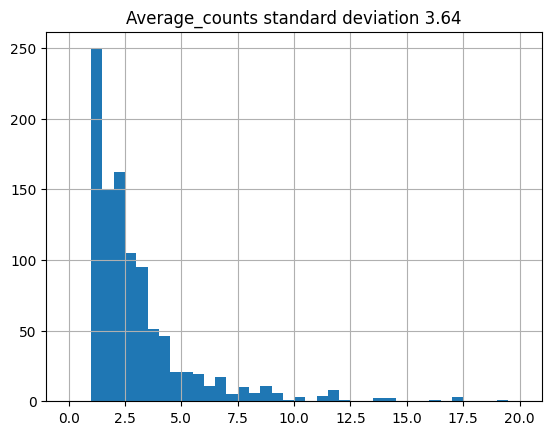

In [202]:
import matplotlib.pyplot as plt

average_counts = client.query_df(sql) 
std = float(average_counts.std())
mean = float(average_counts.mean())
min_ = float(average_counts.min())
max_ = float(average_counts.max())

print(mean, '\n', min_, '\n', max_)

average_counts.hist(column='Average_counts', range=(0, 20), bins=40)

plt.title(f'Average_counts standard deviation {std:.2f}')

Количество средних просмотров по счестчикам отличается в разы, иногда в десятки раз.
Среднее значение около 3 просмотров, при этом т.к. распределение не Гауссово (явно ассиметричное), то использовать правило 
2, 3 сигм здесь не очень уместно. При этом по гистограмме видно, что большенство средних (около 90%) укладывается в интервал [1,4].
Крайне редко встречаются сильно превосходящие средние - от 20 до 70.

Было замечено, что если делать группировку по id счетчика (или юзера), а также получать уникальные id счетчиков с помощью distinct, 
то результаты отличаются от запуска к запуску, но незначительно (колеблются около одного значения)
В sql такого быть не должно, по идее, возможно это внутренные особенности clickhouse. Для меня причины не ясны.

### Задача 4

**Часть хитов помечена как DontCountHits в таблице default.hits. От каких показателей это зависит? Меняется ли данный показатель со временем?**

Можно использовать модели, корреляцию и другие инструменты, которые могут помочь ответить на этот вопрос.

*PS: Если вы решили выполнить "select * from default.hits", то рекомендую проверить, сколько записей вам вернул сервер. Их должно быть около 100 млн.*

*Основной нюанс этой задачи в том, что не всегда можно просто скачать всю таблицу с сервера и анализировать её у себя. Данные в ClickHouse Playground синтетические, поэтому эта задача служит лишь для демонстрации ваших навыков.*

In [ ]:
from tqdm import tqdm

count = int(client.query_df('SELECT COUNT(*) FROM default.hits').values)
assert count == 100*1000*1000

minmax_dates = client.query_df('SELECT MIN(EventDate), MAX(EventDate) FROM default.hits')
DATES_CHUNKS = 100
min_date, max_date = minmax_dates.values.flatten()
date_period = max_date-min_date
dont_counts_hits_by_date = np.zeros(DATES_CHUNKS)
all_request_by_date = np.zeros(DATES_CHUNKS)

sql = '''
SELECT {}
FROM default.hits
ORDER BY EventDate ASC, EventTime ASC
LIMIT {} OFFSET {}
'''

# Меняется ли показатель DontCountHits со временем?
# я думаю, мы можем решить эту часть задачи с помощью группировки в SQL по промежуткам дат
# но если я уловила суть задания, то это не то, что надо показать.
# поэтому попробую работать так, и сделать запросы по кускам для демонстрации.
# Этот цикл занимает минут 15,что долго, но должен давать точный результат.
chunk_size = 65*1000
chunk_numbers = ceil(count/chunk_size)
for i in tqdm(range(chunk_numbers)):
    data = client.query_df(sql.format('DontCountHits, EventDate', chunk_size, chunk_size*i))
    target, date = data['DontCountHits'].values, data['EventDate'].values
    chunk_size = len(data)

    date_chunk_id = (date - min_date)/date_period * (DATES_CHUNKS - 1)
    date_chunk_id = np.ceil(date_chunk_id).astype(int)

    dont_counts_hits_by_date[date_chunk_id] += target
    all_request_by_date[date_chunk_id] += np.ones(chunk_size)  # increment counter

dont_count_hits_ratio_by_date = dont_counts_hits_by_date/all_request_by_date
print(dont_count_hits_ratio_by_date)  # массив из 100 элементов
# вероятно это не лучший метод, и может быть считать стохастически будет лучше. 
# Во время тестов яндекс начал блокировать мои запросы, что может свидетельтсовать что что-то не так, 
# но время было потрачено в основном на другие задачи и больше не осталось.

In [7]:
# ВТОРОЙ ВОПРОС ЗАДАЧИ (работает быстре)
import numpy as np
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=8)

sql = '''
SELECT {}
FROM default.hits
ORDER BY rand()
LIMIT 65000
'''

# Часть хитов помечена как DontCountHits в таблице default.hits. От каких показателей это зависит?
# тут мы не можем идти последовательно по кускам т.к. можем найти ложные кореляции.
# можем стохастически считать кореляцию или обучать модель небольшими батчами.
# для этого получать строки надо будет строго случайно

iters = 100  # set as count/chunk_size as maximum

coefs = []

for i in tqdm(range(iters)):
    data = client.query_df(sql.format('DontCountHits, Age, Sex'))
    target, features = data['DontCountHits'], data[['Age', 'Sex']]

    # preprocess features here
    features['have_Age'] = (features['Age'] != 0).astype(int)
    features['have_Sex'] = (features['Sex'] != 0).astype(int)

    logreg.fit(features, target)
    coefs.append(logreg.coef_)
# так как логистическая регрессия это линейная модель, мы можем их усреднять
# если бы мы строили лес, мы бы добавляли простые деревья к ансамблю
coefs_mean = np.mean(coefs, axis=0)
coefs_std = np.std(coefs, axis=0)
print('coefficents {} +/- {} '.format(coefs_mean, coefs_std))

# На таком простом примере получим довольно стабильные коэффциенты модели, т.к. стандартное отклонение у них маленькое
# вероятно, даже есть какая-то линейная зависимость у фичи "наличие возраста"
# coefficents [[ 0.00792398  0.068473   -0.25712389 -0.03523814]] +/- [[0.00139736 0.0319014  0.07693683 0.08370279]]

coefficents [[ 0.00792398  0.068473   -0.25712389 -0.03523814]] +/- [[0.00139736 0.0319014  0.07693683 0.08370279]] 


### Задача 5

Здесь представлены абсолютно реальные данные из Яндекс.Метрики с некоторыми добавлениями.  
"Target" содержит 1 или 0, где 1 - это конверсия, 0 - нет.  
"Bid" - ставка, которую банк был готов заплатить за клик по рекламе.  
"Расходы" - сколько реально было потрачено за этот клик.  

Колонка "Условие показа объявления" была закодирована:  
"Условие показа объявления hashed" - здесь хэши той же длины, что и реальное слово и, соответственно, имеют ту же частоту.  
"Условие показа объявления embedding" - эмбединги для условия показа объявления.  

Задача: Банку нужно максимизировать конверсии, но при этом не тратить слишком много денег. Конверсию хотелось бы получать не дороже 4000 рублей, а для лендинга action.norvikbank.ru/currency_exchange не дороже 500 рублей.

Размер файла ~250 Мб.

Для работы с parquet могут быть полезны:
pip install pyarrow

In [53]:
import pandas as pd
import pyarrow.parquet as pq
import requests
from io import BytesIO

# url адрес данных
url = "https://storage.yandexcloud.net/norvpublic/metric_for_interviews.parquet"

# Делаем HTTP запрос и сохраняем ответ как поток байтов
r = requests.get(url)
data = r.content

# Открываем поток байтов как parquet файл
table = pq.read_table(BytesIO(data))

# Конвертируем Apache Arrow PyTable в Pandas DataFrame
df:pd.DataFrame = table.to_pandas()

In [52]:
pd.set_option('display.max_columns', 150)
df.head()

,дата визита с временем (мин),id визита,id клиента,Кампания Яндекс.Директа,Группа объявлений,Тип условия показа объявления,utmcontent,время на сайте (сек),регион,округ,размер города,тип сети,рекламная система,марка телефона,операционная система,тип операционной системы,ym_s_ipaddress,ym_s_cookieenabled,ym_s_javascriptenabled,ym_s_browser,matchedkeyword,keyword_id,utmmedium,landing,ym_s_isnewuser,ym_s_screenformat,placement,расходы,bid,target,Условие показа объявления embedding,Условие показа объявления hashed
0,2023-03-27 00:32:00+00:00,1492538189036126363,1679866369380985225,83101661,5130020019,<NA>,group_5130020019_banner_13472642339_device_mob...,8,Республика Татарстан,Приволжский федеральный округ,Миллионер (более 800 тыс.),<NA>,Яндекс: Директ,xiaomi,android,mobile_Android,83.220.238.xxx,1,1,chromemobile,<NA>,43260174282,search,action.norvikbank.ru/credit_1,1,9:21,Яндекс,17.08,77.0,0,"[-0.025403419509530067, 0.0008466679719276726,...",d0633b 4575eb
1,2023-03-27 00:46:00+00:00,1492753384505344130,1679867202359463034,84460901,5148420803,additional,group_5148420803_banner_13648891761_device_mob...,15,Москва и Московская область,Центральный федеральный округ,Мультимиллионер (более 2 млн.),<NA>,Яндекс: Директ,motorola,android,mobile_Android,31.173.80.xxx,1,1,chromemobile,<NA>,43694449049,search,norvikbank.ru/lp/refinancing,1,9:21,Яндекс,NaN,NaN,0,"[-0.0059991320595145226, -0.014896205626428127...",37f936f1647bcb66 446f6f b76 4d3e3
2,2023-03-27 00:49:00+00:00,1492795918507573312,1679867364911838990,73266426,4883778384,additional,group_4883778384_banner_12006749216_device_mob...,176,Москва и Московская область,Центральный федеральный округ,Мультимиллионер (более 2 млн.),wi_fi,Яндекс: Директ,xiaomi,android,mobile_Android,31.173.82.xxx,1,1,chromemobile,<NA>,38082984228,search,norvikbank.ru/lp/secured-loan,1,9:16,Яндекс,NaN,NaN,0,"[-0.004147370345890522, 0.007261834107339382, ...",8c4dbef21b13 4d3e3 4941d862e239
3,2023-03-27 00:56:00+00:00,1492907643497611594,1679867790182918776,83101661,5130020019,<NA>,group_5130020019_banner_13472642339_device_des...,1,Республика Татарстан,Приволжский федеральный округ,Миллионер (более 800 тыс.),<NA>,Яндекс: Директ,<NA>,macos,desktop,94.25.169.xxx,1,1,safari,<NA>,43260174282,search,action.norvikbank.ru/credit_1,1,4:3,Яндекс,17.08,77.0,0,"[-0.025403419509530067, 0.0008466679719276726,...",d0633b 4575eb
4,2023-03-27 00:58:00+00:00,1492941307608301685,167986791979834461,71055059,4814182501,additional,group_4814182501_banner_11701152844_device_mob...,82,Москва и Московская область,Центральный федеральный округ,Мультимиллионер (более 2 млн.),wi_fi,Яндекс.Директ: Не определено,samsung,android,mobile_Android,31.173.86.xxx,1,1,chromemobile,<NA>,36288862077,search,norvikbank.ru/lp/secured-loan,1,8,Яндекс,NaN,NaN,0,"[-0.019182218238711357, -0.012728818692266941,...",d0633b b91e b76 4d3e3


Решение данной задачи находится в файле task5.py

-----------------

Для начала скачиваем данные и сохраняем их в файл для дальнейшей работы с ним.

Проведем первичный анализ по фичам, которые у нас есть на данный момент.
- Дата и время. необходимо будет их преобразовать, потому что в том формате, что они есть сейчас, они нам не подходят
- id визита уникальны
- id клиента не уникальны. в чистом виде использовать эту фичу не будем, преобразуем ее в бинарную - является данный id клиента уникальным, или нет
- utm content выглядит как ссылка, в которой содержится важная информация о клике. часть данных оттуда уже вытащена в таблицу, но данные по "position" и "banner" я не увидела. 
- "рекламные системы" нужно будет преобразовать в бинарный вид
- фичи "операционная система" и "тип операционной системы" пересекаются. но на данном этапе не будем их преобразовывать и загрузим в модель, как есть
- ym_s_ipaddress не уникальны, и не сильно информативны, эту фичу удалим
- ym_s_javascriptenable тоже удалим, т.к. для все записи имеют одинаковое значение
- фича matched_keyword на данный момент выглядит не информативно. преобразовывать её не будем, но в идеале нужно сделать one-hot-encoding для каждого ключевого слова, т.к. сейчас это слитный и не информативный для модели текст
- utm medium тоже удаляем, имеет одно значение для всех - search
- embedding представлен в виде массива. для удобства его необходимо перевести в столбцы датафрейма

Подготовка данных.
- удаляем столбцы, которые считаем неиформативными, преобразовываем некоторые столбцы по плану выше
- заполним пропуски. в колонке bids в пропуски запишем среднее по столбцу,  в остальных местах заменим их на 'no_information'. пропуски в "расходах" пока не трогаем
- удалим строки с <NA> в "Условие показа объявления" embedding и hashed.
- извлечем ещё два признака из utmcontent (device и position)
- разделяем данные на 2 датасета - в одном просмотры, которые пришли с лэндинга action.norvikbank.ru/currency_exchange, в другом все остальные.
 

В наборе данных с лэндинга action.norvikbank.ru/currency_exchange нет ни одного таргета. Из этого можно сделать вывод, что либо нынешняя компания не эффективна, т.к. не было привлечено ни одного клиента (при этом показов было около 4000), либо предложение банка по рынку сильно проигрывает. 
В данной работе не вижу смысла анализировать эти данные, т.к. без таргета мы не сможем получить данные, какие же объявления или кампании выгрышные, мы можем только проанализировать как делать "не надо".

По второму набору данных всё ок, единственное много пропуском в колонке "расходы". Отсутствующие строки с данными придется удалить, так как подстановка среднего или моды может исказить картину.

Анализ данных.
Для начала построим модель, которая будет предсказывать наш таргет и посмотрим, какие фичи имеют наибольшее влияние. 
Будем использовать CatBoostClassifier, т.к. у нас много категориальный фич.
    
Выведем важность признаков

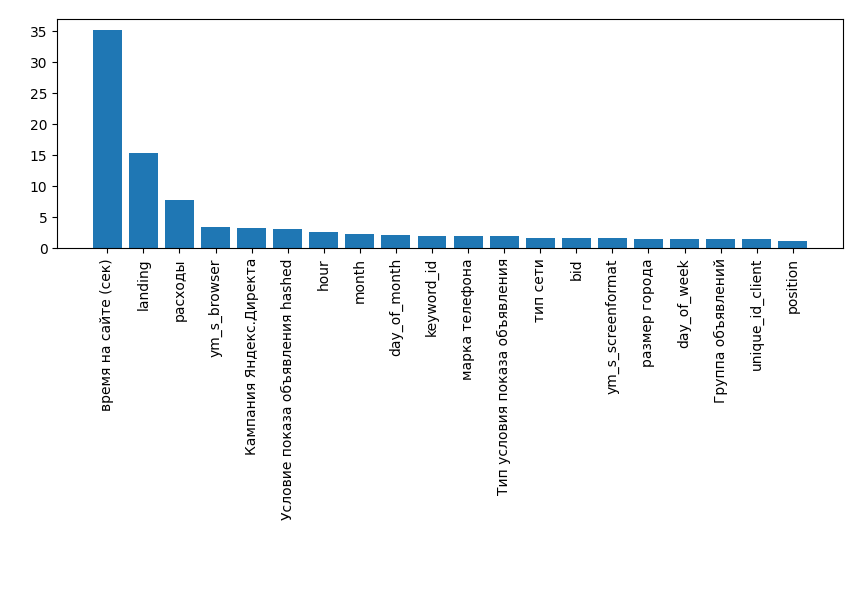
Больше всего на модель оказывает влияние время на сайте, лендинг и расходы. Время на сайте - ожидаемо, но это скорее следствие, а не то, чем мы можем управлять, в отличие от лендинга и расходов.
    
Посмотрим также, как обучилась наша модель.
Проверим на тех же данных (обычно хорошо оставить часть данных для теста, но в данном случае это не так важно)
Для оценки будем использовать график precision-recall.
По графику видим, что модель обучилась хорошо, average precision 0.8
    
    
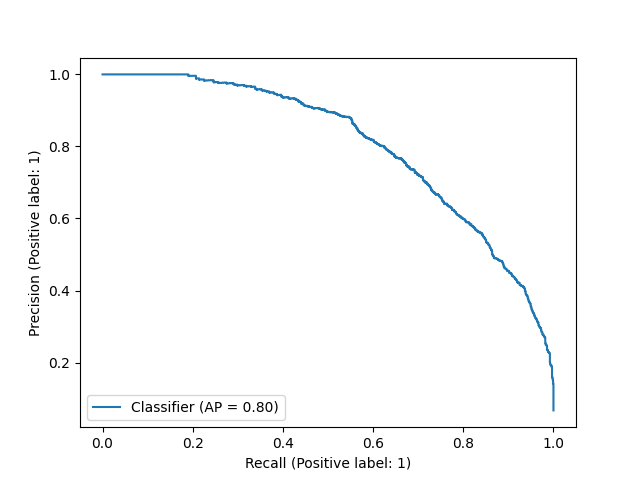
    
Т.к. очень похожие показы рекламы могут иметь разные исходы из-за ненаблюдаемых факторов нам надо как-то аппрокисировать каждый показ, для этого подойдет "вероятность" из обученной модели.
Из модели для каждой строчки возьмем вероятность, что она окажется с таргетом = 1.
И создадим столбец 'prob_to_cost', в котором будет отношение вероятности к цене клиента ("расходы").
В идеале, нам нужны просмотры, которые с большой вероятностью станут таргет = 1, при этом имея самую низкую цену.
Отсортируем записи по убыванию по колонке 'prob_to_cost'.
Впоследствии можно будет выбрать первые записи (до тех пор, пока нас будет удовлетворять цена клиента), и проанализировать, какими характеристиками обладают данные просмотры.

Интересно посмотреть графики зависимостей по каждому столбцу (оранжевой точкой отмечено среднее)
    
По дням недели
    
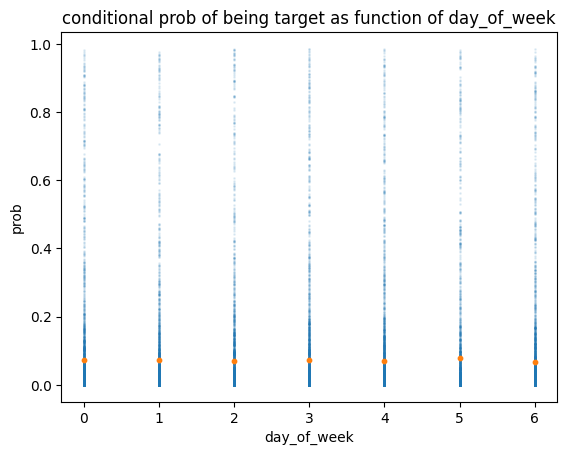
    
По дням в месяце
    
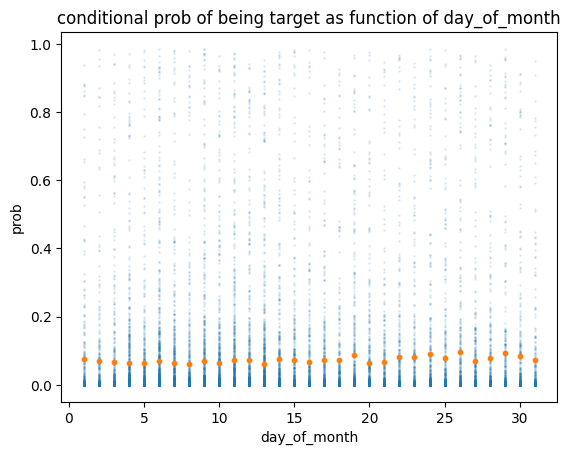
    
По тому, уникальный id клиента или нет
    
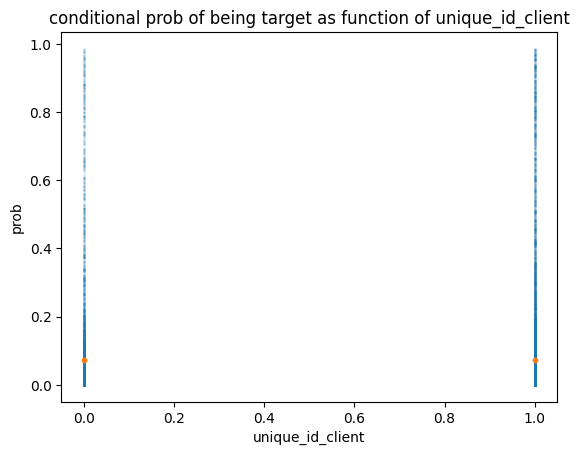
    
По часу (данные не скорректированы на часовой регион, поэтому не сильно информативны)
    
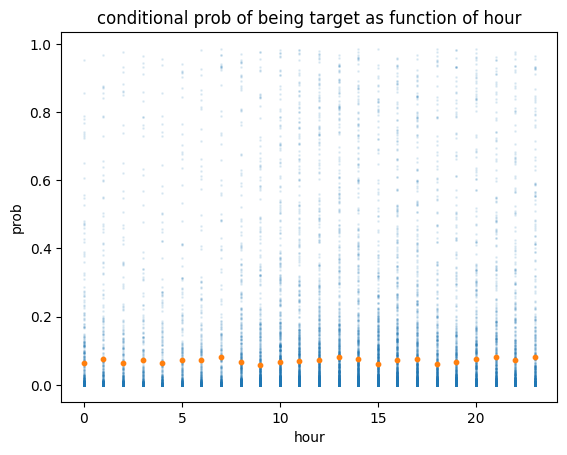
    
По признаку "position"
    
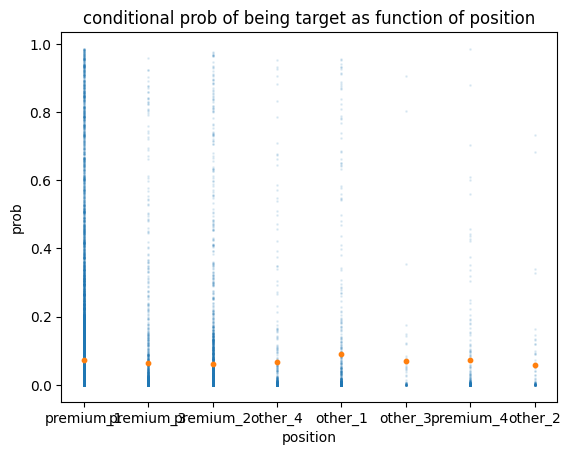
    
По признаку "device"
    
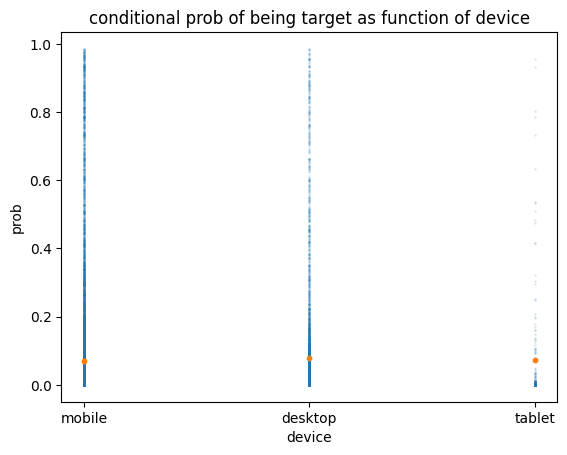
    
По типу условия показа объявления
    
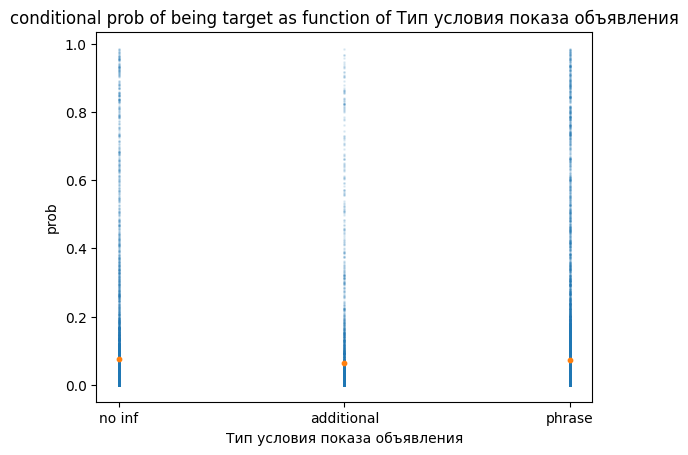
    
По времени на сайте
    
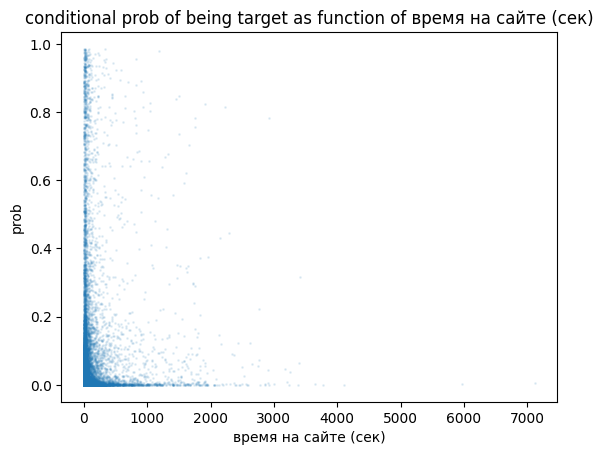
    
По группе объявлений (внизу плохо отобразились номера групп)
    
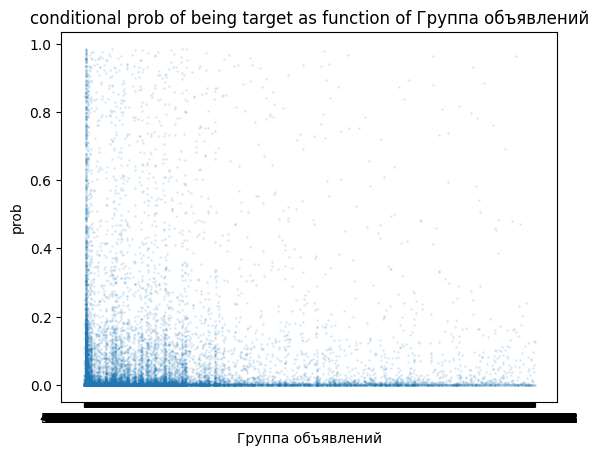
    
По кампании яндекс.директа

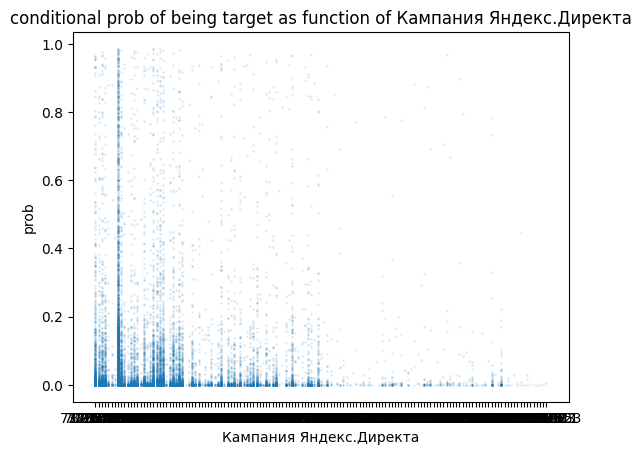
    
По региону
    
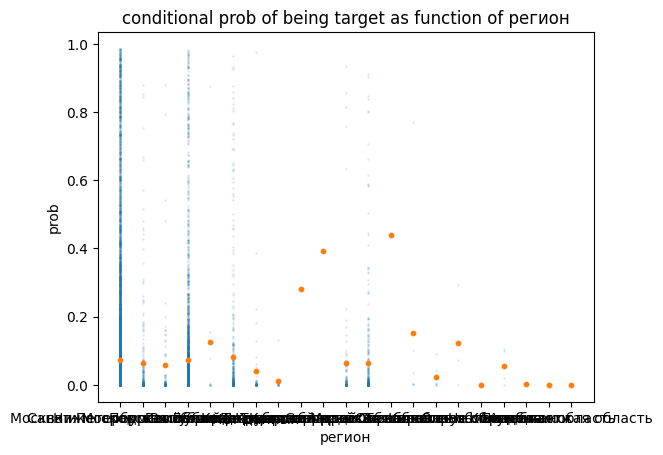
    
И по округу
    
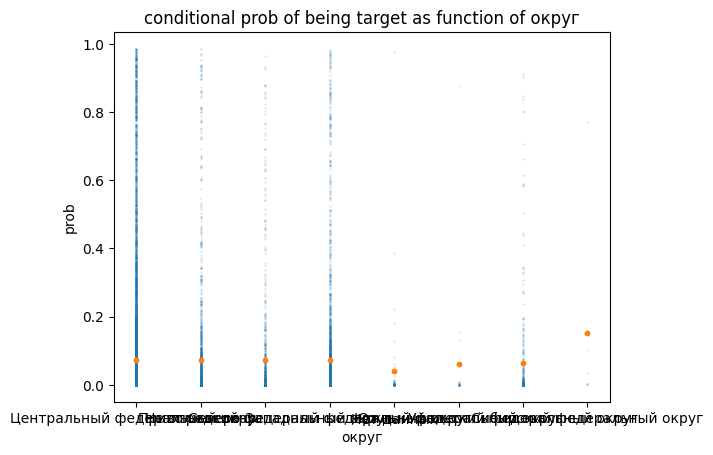

По графикам нет визуально заметных отклонения условной вероятности (за исключением мест, где измерений было очень мало и среднее могло быть смещено. Возможно, конечно, что в каких-то малых городах банковский продукт был более нужен, но скорее всего это неточность статистики). Непрерывные величины или величины с большим числом категорий на графиках в принципе не интерпретируют.
При дальнейшей работе стоит посчитать все условные вероятности (там где достаточно измерений), используя гистограммы и попытаться выявить фичи которые влияют на результат. Сделать гипотезу и провести тест для её подтверждения.

Еще один способ, который не успела тут рассмотреть это сгруппировать все данные по таргету и сравнить распредления каждой фичи при условии target==1 и target==0, если эти распредления будут иметь различия, то можно найти на чем эти различия и сделать гипотезу. При этом способе обучить модель предсказывать target не требуется.